In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

from ml_utils import imshow, img_to_nparray, find_img_stat, get_image_filepaths

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (10,5)

cudnn.benchmark = True
plt.ion() # interactive mode

DRIVE = False
MOUNTED = False

In [2]:
from PIL import Image

data_dir  = "/content/drive/MyDrive/zelovoc/dataset/" if DRIVE else ""
data_dir = "dataset/"

if DRIVE and not MOUNTED:
    from google.colab import drive
    drive.mount("/content/drive")
    MOUNTED = True

# Exploratory data analysis

Lets take a closer look, at what are we even working with in the first place

**TODO**:
1. Plot sizes of images

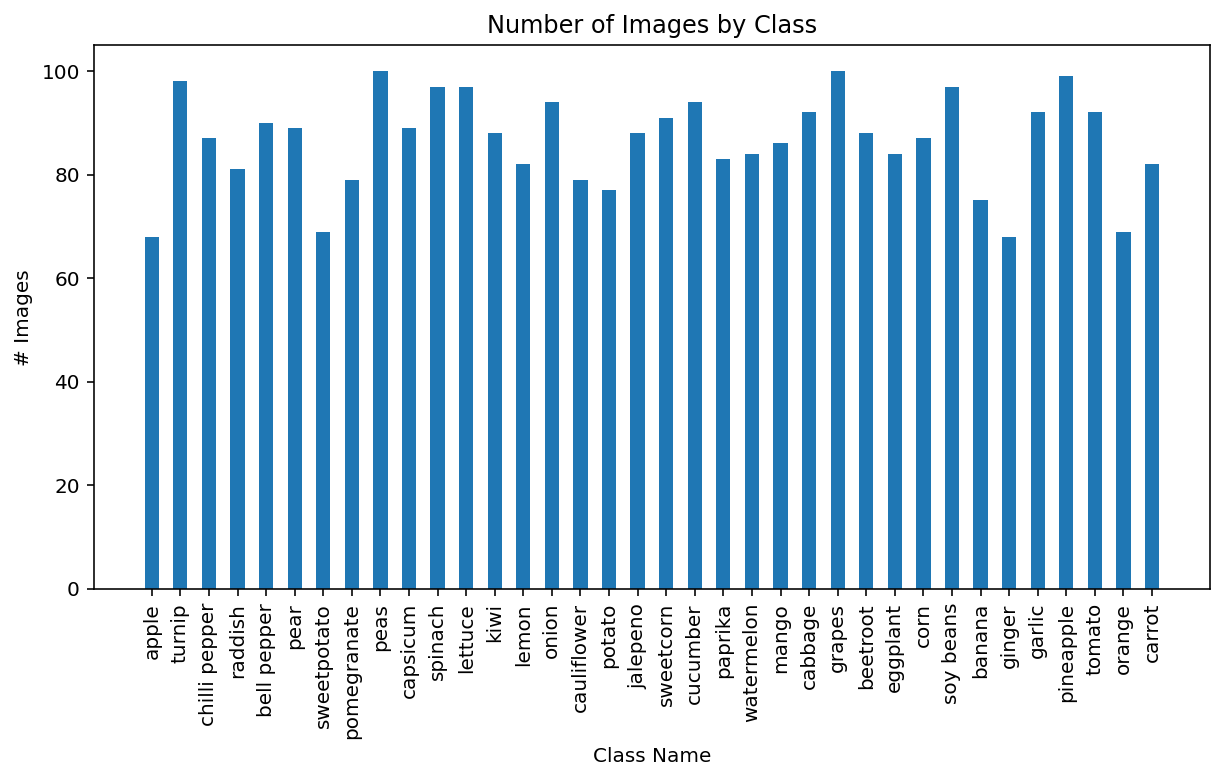

In [3]:
classes = { class_: len( os.listdir( f"{ data_dir }/train/{ class_ }" ) ) for class_ in os.listdir( os.path.join( data_dir, "train" ) ) }

plt.bar(classes.keys(), classes.values(), width = 0.5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.xticks(rotation='vertical')
plt.ylabel('# Images');

The ratio between single classes is quite balanced, we probably will not need to discard any of the images because of uneven ratios.

Now l

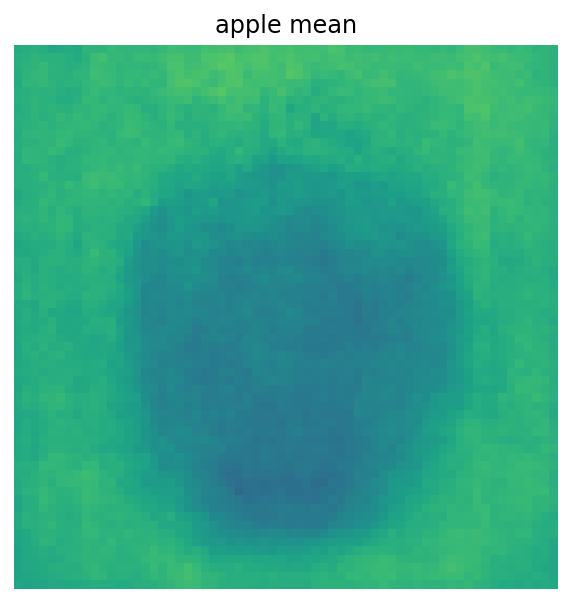

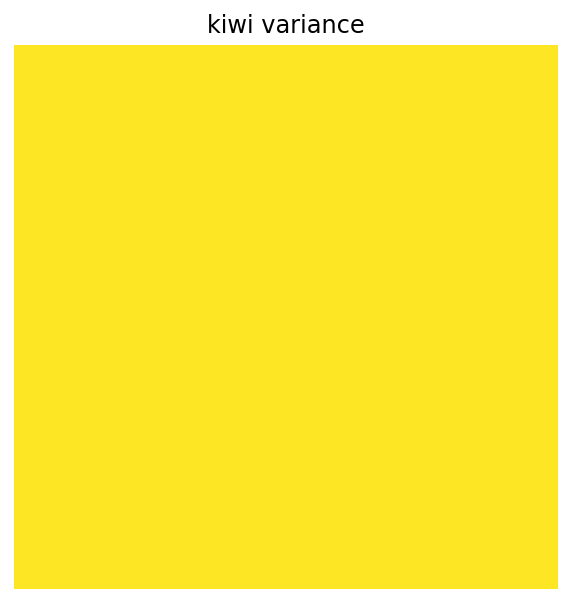

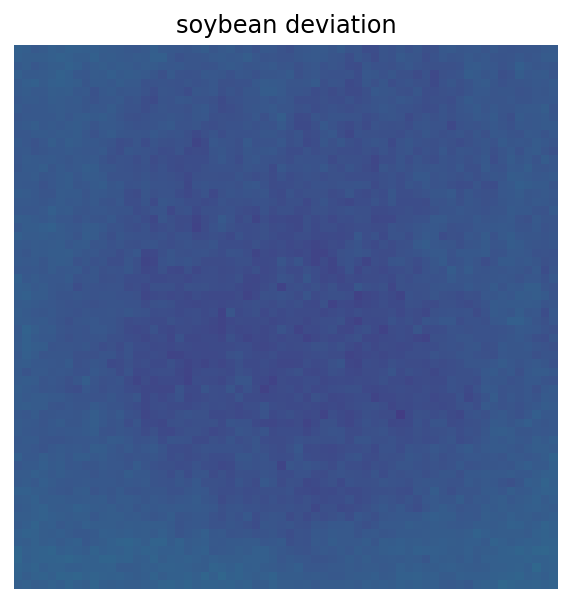

In [4]:
apple_images = img_to_nparray( os.path.join( data_dir, "train", "apple" ), get_image_filepaths( "apple" ) )
kiwi_images = img_to_nparray( os.path.join( data_dir, "train", "kiwi" ), get_image_filepaths( "kiwi" ) )
soybean_images = img_to_nparray( os.path.join( data_dir, "train", "soy beans" ), get_image_filepaths( "soy beans" ) )

apple_mean = find_img_stat( apple_images, "apple mean", f=np.mean, axis=0 )
kiwi_var = find_img_stat( kiwi_images, "kiwi variance", f=np.var, axis=0 )
pineapple_dev = find_img_stat( soybean_images, "soybean deviation", f=np.std, axis=0 )

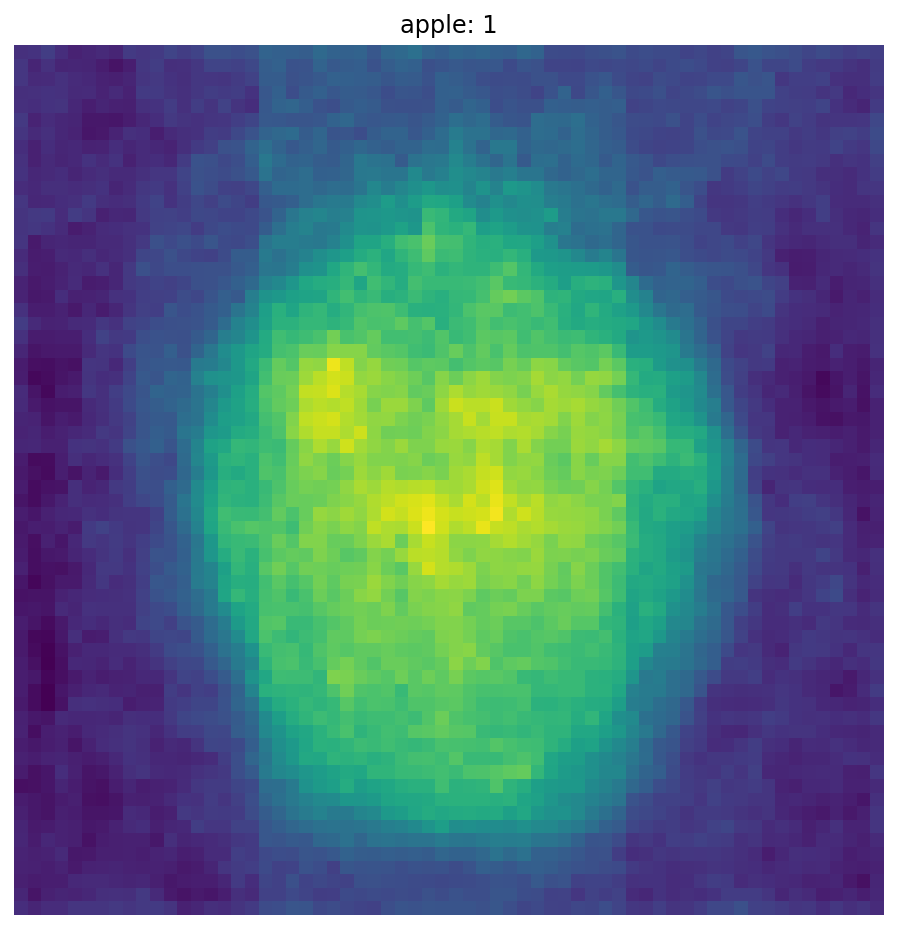

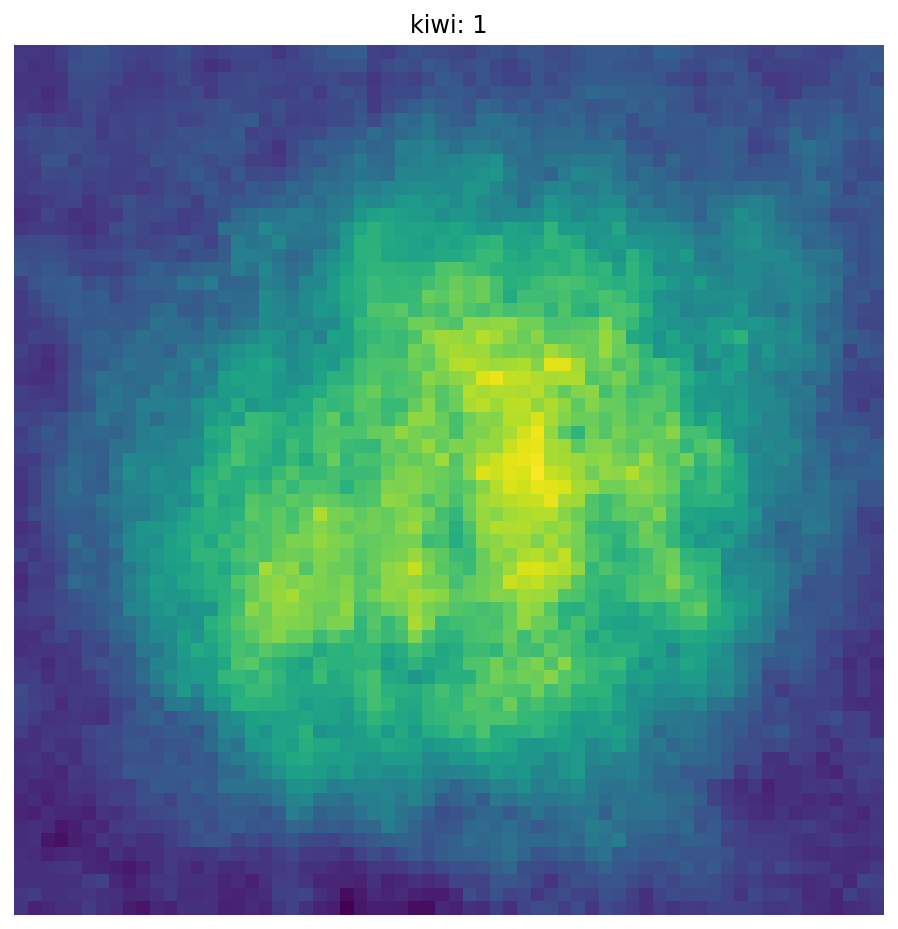

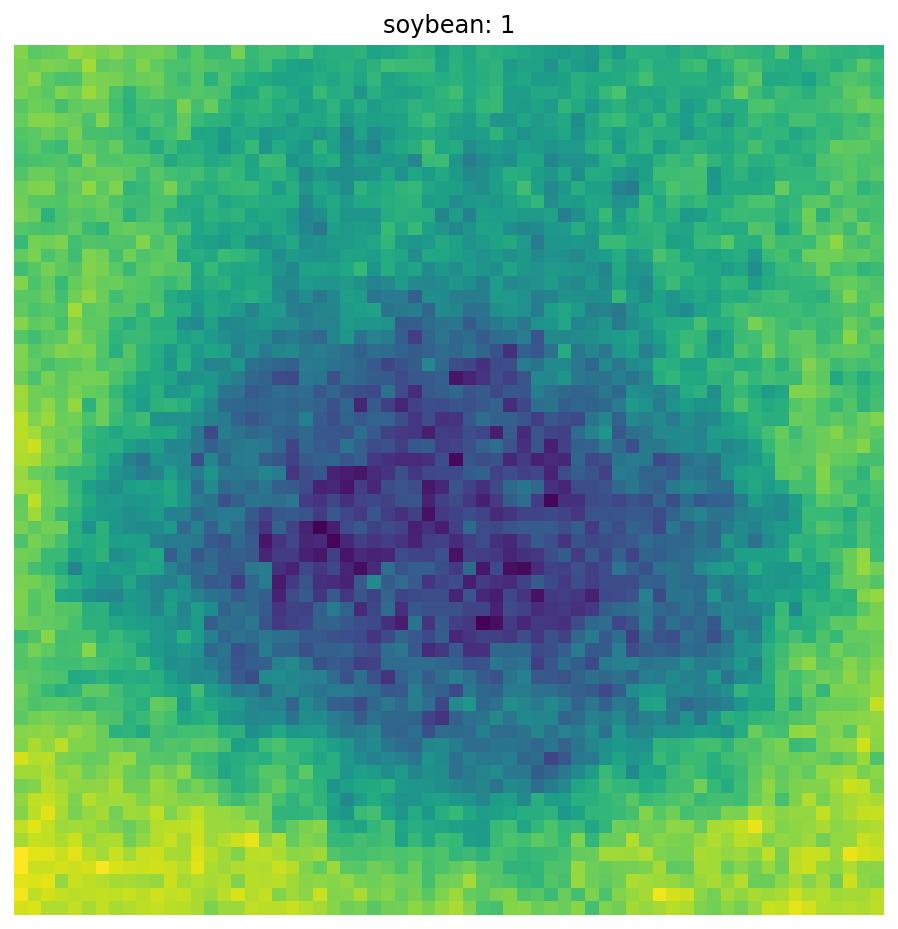

In [5]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages( matrix, n_components = 0.3, size = (64, 64)):
    pca = PCA( n_components=n_components, whiten=True )
    pca.fit( matrix )
    return pca
  
def plot_pca( pca, title, size = (64, 64) ):
    n = pca.n_components_
    fig = plt.figure( figsize=( 8, 8 ) )
    
    r = int( n ** 0.5 )
    c = ceil( n / r)
    
    for i in range(n):
        ax = fig.add_subplot( r, c, i + 1, xticks=[], yticks=[] )
        ax.imshow( pca.components_[ i ].reshape( size ) )
        plt.title( f"{ title }: { i + 1 }" )
    plt.axis( "off" )
    plt.show()
    
plot_pca( eigenimages( apple_images ), "apple" )
plot_pca( eigenimages( kiwi_images ), "kiwi" )
plot_pca( eigenimages( soybean_images ), "soybean" )

# Data preparation

This step is quite simple. To be able to feed our model with data, we basically only need to convert each picture to tensor with 3 layers, where each layer corresponds for one of the RGB channels in original picture

Aside form that, for training data we also augment the data to decrease model variance

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), # helps fight the bias in input images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder( os.path.join( data_dir, x ), data_transforms[ x ] ) 
    for x in [ "train", "validation" ]
}

dataloaders = {
    x: torch.utils.data.DataLoader( image_datasets[x], batch_size=4, shuffle=True, num_workers=2 )
    for x in [ "train", "validation" ]
}

dataset_sizes = {
    x: len( image_datasets[ x ] )
    for x in [ "train", "validation" ]
}

class_names = image_datasets["train"].classes

device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu" )

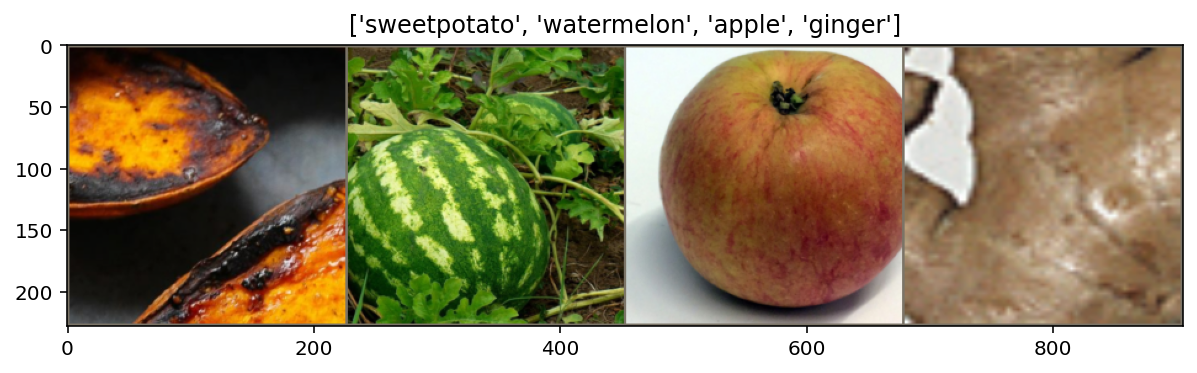

In [7]:
# Get a batch of training data
inputs, classes = next( iter( dataloaders[ "train" ] ) )

# Make a grid from batch
out = torchvision.utils.make_grid( inputs )

imshow( out, title=[ class_names[ x ] for x in classes ] )

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)
        
        # each epoch has training and validating phase
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # load the best model weights
    model.load_state_dict( best_model_wts )
    return model

In [9]:
def visualize_model( model, num_images=6 ):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Model tweaking

We will use prebuilt pytorch Resnet18 model

In [10]:
model_ft = models.resnet18( pretrained=True )
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear( num_ftrs, len( class_names ) )

model_ft = model_ft.to( device )

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD( model_ft.parameters(), lr=0.001, momentum=0.9 )

exp_lr_scheduler = lr_scheduler.StepLR( optimizer_ft, step_size=7, gamma=0.1 )

# Model training

With this configuration, we have been able to achieve ~95% accuracy with only 25 epochs.

In [11]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=35)

# model = torch.load( "resnet.pth" )
model = torch.load( "resnet.pth", map_location=torch.device( "cpu" ) ) # if gpu is not available

# Model evaluation

Observe the accuracy

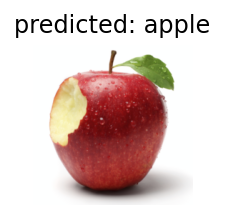

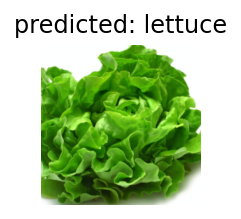

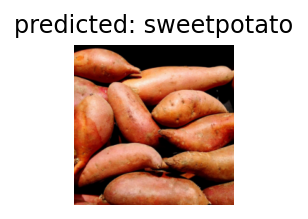

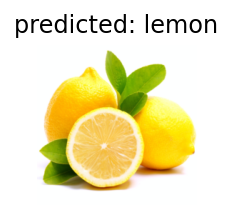

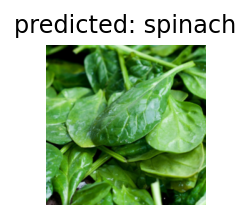

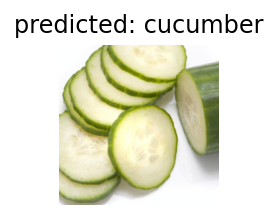

In [12]:
visualize_model(model)
plt.ioff()
plt.show()